#  PART 1: FEATURE ENGINEERING & DATA CLEANING
### Building Predictive Signals from Raw OHLCV Data

This notebook transforms 100 anonymized assets' raw price/volume data into engineered features. We construct 47 technical indicators spanning momentum, volatility, volume dynamics, and mean-reversion patterns, then prune redundant features using correlation analysis.

In [1]:
# Import required libraries
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import time

# Configuration
pd.set_option('display.float_format', lambda x: '%.5f' % x)
plt.style.use('seaborn-v0_8-darkgrid')

---
## 🔄 STEP 1: DATA LOADING & STANDARDIZATION

Load 100 anonymized asset CSVs from `archive/anonymized_data/` and standardize column names. Each asset contains OHLCV data spanning multiple years, which we'll concatenate into a unified multi-index DataFrame (Date × Ticker).

In [2]:
# Load all stock data files
print("Loading data from folder...")

data_folder = 'archive/anonymized_data'
all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]

frames = []

for filename in all_files:
    file_path = os.path.join(data_folder, filename)
    df_temp = pd.read_csv(file_path)
    
    # Standardize column names (lowercase to capitalized)
    df_temp.columns = df_temp.columns.str.lower()
    
    column_map = {
        'date': 'Date', 'open': 'Open', 'high': 'High', 
        'low': 'Low', 'close': 'Close', 'volume': 'Volume',
        'd': 'Date', 'o': 'Open', 'h': 'High', 'l': 'Low', 'c': 'Close', 'v': 'Volume'
    }
    df_temp.rename(columns=column_map, inplace=True)
    
    # Remove duplicate columns (keep first occurrence)
    df_temp = df_temp.loc[:, ~df_temp.columns.duplicated()]
    
    # Select only the standard columns
    df_temp = df_temp[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
    df_temp['Date'] = pd.to_datetime(df_temp['Date'])
    
    # Add ticker identifier
    ticker_name = filename.replace('.csv', '')
    df_temp['Ticker'] = ticker_name
    frames.append(df_temp)

# Combine all files
df = pd.concat(frames, ignore_index=True)
df.set_index(['Ticker', 'Date'], inplace=True)
df.sort_index(inplace=True)

print(f"Data Loaded: {df.shape[0]} rows, {df.shape[1]} columns")
print(f"Unique Stocks: {df.index.get_level_values(0).nunique()}")

Loading data from folder...
Data Loaded: 251100 rows, 5 columns
Unique Stocks: 100


In [3]:
# Data cleaning and validation
df['Close'] = df.groupby(level='Ticker')['Close'].ffill()
df['Open'] = df['Open'].fillna(df['Close'])
df['High'] = df['High'].fillna(df['Close'])
df['Low'] = df['Low'].fillna(df['Close'])
df['Volume'] = df['Volume'].fillna(0)

original_len = len(df)
df = df[(df['Close'] > 0) & (df['Volume'] > 0)]
print(f"✓ Cleaned: Dropped {original_len - len(df)} invalid rows")

✓ Cleaned: Dropped 1 invalid rows


In [4]:
# Data quality checks
assert isinstance(df.index, pd.MultiIndex) and df.index.names == ['Ticker', 'Date']
assert df.index.duplicated().sum() == 0

date_range = df.index.get_level_values('Date')
print(f"✓ Quality: {date_range.min().date()} → {date_range.max().date()}, {len(df):,} rows, {df.index.get_level_values('Ticker').nunique()} tickers")

✓ Quality: 2016-01-25 → 2026-01-16, 251,099 rows, 100 tickers


In [5]:
# Feature engineering: Log Returns with winsorization (outlier capping)
def winsorize_by_group(s, q_low=0.01, q_high=0.99):
    return s.clip(lower=s.quantile(q_low), upper=s.quantile(q_high))

raw_log_ret = np.log(df['Close'] / df.groupby(level='Ticker')['Close'].shift(1))
df['Log_Ret_Raw'] = raw_log_ret
df['Log_Ret'] = raw_log_ret.groupby(level='Ticker').transform(winsorize_by_group)

---
## 🔧 STEP 2: TECHNICAL FEATURE ENGINEERING
### Creating 47 Features: Momentum, Volatility, Volume, Mean-Reversion

Construct 4 categories of predictive signals:
- **Momentum**: Returns at 1/5/10/20/60-day horizons, RSI, rate-of-change
- **Volatility**: Rolling standard deviations, Parkinson estimator, volatility ratios
- **Volume**: Turnover, volume MA ratios, on-balance volume
- **Mean-Reversion**: Distance from moving averages, Bollinger Band positions

In [6]:
# Basic technical indicators
delta = df.groupby(level='Ticker')['Close'].diff()
up, down = delta.clip(lower=0), -delta.clip(upper=0)
roll_up = up.groupby(level='Ticker').ewm(alpha=1/14, adjust=False).mean().droplevel(0)
roll_down = down.groupby(level='Ticker').ewm(alpha=1/14, adjust=False).mean().droplevel(0)
df['RSI_14'] = 100.0 - (100.0 / (1.0 + roll_up / roll_down))

df['Vol_20d'] = df.groupby(level='Ticker')['Log_Ret'].ewm(span=20, adjust=False).std().droplevel(0) * np.sqrt(252)

df['Dollar_Vol'] = df['Close'] * df['Volume']
df['Amihud_Illiq'] = df['Log_Ret'].abs() / (df['Dollar_Vol'] + 1e-9)
df['Amihud_Rank'] = df.groupby('Date')['Amihud_Illiq'].rank(pct=True)

df['Rel_Str_Market'] = df['Log_Ret'] - df.groupby('Date')['Log_Ret'].transform('median')

# Momentum, volatility, and volume features
for h in (5, 20, 60):
    df[f'Mom_{h}d'] = df.groupby(level='Ticker')['Log_Ret'].rolling(h).sum().droplevel(0)

for span in (10, 60):
    df[f'Vol_EWM_{span}'] = df.groupby(level='Ticker')['Log_Ret'].ewm(span=span, adjust=False).std().droplevel(0) * np.sqrt(252)

df['HL_Range'] = (df['High'] - df['Low']) / df['Close']
df['OC_Gap'] = (df['Open'] - df.groupby(level='Ticker')['Close'].shift(1)) / df.groupby(level='Ticker')['Close'].shift(1)
df['Log_Volume'] = np.log1p(df['Volume'])
df['Vol_Z_20d'] = df.groupby(level='Ticker')['Log_Volume'].rolling(20).apply(
    lambda x: (x.iloc[-1] - x.mean()) / (x.std(ddof=0) + 1e-12), raw=False
).droplevel(0)

vol_map = {5: 'Vol_EWM_10', 20: 'Vol_EWM_10', 60: 'Vol_EWM_60'}
for h in (5, 20, 60):
    df[f'Mom_Vol_Adj_{h}d'] = df[f'Mom_{h}d'] / (df[vol_map[h]] / np.sqrt(252) + 1e-8)

In [7]:
# Advanced alpha signals: Cross-sectional ranks, reversal, volume-price, regime features
for h in [5, 20, 60]:
    df[f'Mom_{h}d_Rank'] = df.groupby('Date')[f'Mom_{h}d'].rank(pct=True)

df['Vol_20d_Rank'] = df.groupby('Date')['Vol_20d'].rank(pct=True)
df['Volume_Rank_20d'] = df.groupby('Date')['Log_Volume'].rank(pct=True)
df['RSI_Rank'] = df.groupby('Date')['RSI_14'].rank(pct=True)

df['Ret_1d'] = df.groupby(level='Ticker')['Log_Ret'].shift(1)
df['Ret_5d'] = df.groupby(level='Ticker')['Log_Ret'].rolling(5).sum().droplevel(0)
df['Ret_1d_Rank'] = df.groupby('Date')['Ret_1d'].rank(pct=True)
df['Ret_5d_Rank'] = df.groupby('Date')['Ret_5d'].rank(pct=True)
df['Reversal_1d'] = 1 - df['Ret_1d_Rank']
df['Reversal_5d'] = 1 - df['Ret_5d_Rank']

df['OBV_Raw'] = (np.sign(df['Log_Ret']) * df['Volume']).groupby(level='Ticker').cumsum()
df['OBV_Change_20d'] = df.groupby(level='Ticker')['OBV_Raw'].pct_change(20)
df['VWAP_Dev'] = (df['Close'] - df['Close']) / df['Close']
vol_ma_20 = df.groupby(level='Ticker')['Volume'].rolling(20).mean().droplevel(0)
df['Volume_Surge'] = (df['Volume'] / (vol_ma_20 + 1)) - 1
df['Vol_Mom_Corr_20d'] = df.groupby(level='Ticker').apply(
    lambda g: g['Log_Ret'].rolling(20).corr(g['Log_Volume'])
).droplevel(0)

df['Dollar_Vol_Rank'] = df.groupby('Date')['Dollar_Vol'].rank(pct=True)
df['Amihud_Rank_CS'] = df.groupby('Date')['Amihud_Illiq'].rank(pct=True)
df['Spread_Proxy'] = df['HL_Range']
df['Spread_Rank'] = df.groupby('Date')['Spread_Proxy'].rank(pct=True)
df['Turnover'] = df['Volume'] / (df['Close'] + 1e-9)
df['Turnover_Rank'] = df.groupby('Date')['Turnover'].rank(pct=True)

vol_10d = df.groupby(level='Ticker')['Log_Ret'].rolling(10).std().droplevel(0) * np.sqrt(252)
vol_60d = df.groupby(level='Ticker')['Log_Ret'].rolling(60).std().droplevel(0) * np.sqrt(252)
df['Vol_Ratio_10_60'] = vol_10d / (vol_60d + 1e-9)
df['Vol_Percentile'] = df.groupby(level='Ticker')['Vol_20d'].rolling(252).apply(
    lambda x: (x.iloc[-1] > x).sum() / len(x) if len(x) > 0 else 0.5, raw=False
).droplevel(0)
df['Vol_Rank_CS'] = df.groupby('Date')['Vol_20d'].rank(pct=True)

market_dispersion = df.groupby('Date')['Log_Ret'].std()
df['Market_Dispersion'] = df.index.get_level_values('Date').map(market_dispersion)
market_ret_daily = df.groupby('Date')['Log_Ret'].mean()
df['Market_Ret'] = df.index.get_level_values('Date').map(market_ret_daily)
df['Beta_60d'] = df.groupby(level='Ticker').apply(
    lambda g: g['Log_Ret'].rolling(60).corr(g['Market_Ret'])
).droplevel(0)
df['Idio_Vol'] = df['Vol_20d'] * np.sqrt(1 - np.clip(df['Beta_60d']**2, 0, 0.99))
df['Rel_Volume'] = df['Log_Volume'] - df.groupby('Date')['Log_Volume'].transform('mean')

df['Quality_Mom'] = df['Mom_20d_Rank'] * (1 - df['Vol_Rank_CS'])
df['Mom_Vol_Conviction'] = df['Mom_20d_Rank'] * df['Volume_Rank_20d']
df['Reversal_Dispersion'] = df['Reversal_5d'] * df['Market_Dispersion']
df['Mom_Illiquid'] = df['Mom_20d_Rank'] * df['Amihud_Rank_CS']

print(f"✓ Features: {len(df.columns)} total")

✓ Features: 60 total


In [8]:
# Cleanup and save
before = len(df)
df.dropna(inplace=True)
print(f"✓ Complete: {df.shape[0]:,} rows ({before - len(df)} dropped), {df.shape[1]} features")

df.to_parquet('clean_features_v2_advanced.parquet')
print(f"✓ Saved: clean_features_v2_advanced.parquet ({os.path.getsize('clean_features_v2_advanced.parquet') / 1024**2:.1f} MB)")

✓ Complete: 225,799 rows (25300 dropped), 60 features
✓ Saved: clean_features_v2_advanced.parquet (77.3 MB)


In [9]:
# Save to Parquet file
output_file = 'clean_features_v2_advanced.parquet'
df.to_parquet(output_file)
print(f"✓ Data saved to: {output_file}")
print(f"File size: {os.path.getsize(output_file) / 1024 / 1024:.2f} MB")
print(f"\n🎯 This dataset includes ADVANCED alpha signals:")
print(f"   - Cross-sectional ranks for relative performance")
print(f"   - Mean reversion signals")
print(f"   - Volume-price divergence")
print(f"   - Liquidity premium factors")
print(f"   - Volatility regime detection")
print(f"   - Market correlation/dispersion")
print(f"   These should provide much stronger predictive power!")

✓ Data saved to: clean_features_v2_advanced.parquet
File size: 77.31 MB

🎯 This dataset includes ADVANCED alpha signals:
   - Cross-sectional ranks for relative performance
   - Mean reversion signals
   - Volume-price divergence
   - Liquidity premium factors
   - Volatility regime detection
   - Market correlation/dispersion
   These should provide much stronger predictive power!


---
## ✂️ STEP 3: CORRELATION ANALYSIS & FEATURE PRUNING
### Removing Multicollinearity (Threshold: 0.8)

Compute pairwise feature correlations and iteratively drop highly correlated features (|r| > 0.8) to reduce redundancy. This prevents overfitting and improves model generalization by keeping only orthogonal information sources.

In [10]:
# Feature pruning: Keep 30 core features + OHLCV + Log_Ret
df_full = pd.read_parquet('clean_features_v2_advanced.parquet')
print(f"Pruning: {df_full.shape[1]} features → 36 features")

# Core feature set for L/S equity alpha
KEEP_FEATURES = [
    # Market data (always keep)
    'Open', 'High', 'Low', 'Close', 'Volume',
    'Log_Ret',  # Target variable
    
    # === TIER 1: CROSS-SECTIONAL RANKS (7) ===
    # Most important for equity L/S - relative performance
    'Mom_20d_Rank',      # Core momentum signal
    'Mom_60d_Rank',      # Long-term momentum
    'Vol_Rank_CS',       # Low vol anomaly (NOT Vol_20d_Rank - duplicate)
    'Volume_Rank_20d',   # Relative volume
    'RSI_Rank',          # Overbought/oversold
    'Amihud_Rank_CS',    # Illiquidity premium (NOT Amihud_Rank - duplicate)
    'Dollar_Vol_Rank',   # Size/liquidity
    
    # === TIER 2: REVERSAL SIGNALS (3) ===
    # Mean reversion complements momentum
    'Reversal_1d',       # Short-term reversal (NOT Ret_1d_Rank - duplicate)
    'Reversal_5d',       # Medium-term reversal (NOT Ret_5d_Rank - duplicate)
    'Ret_1d',            # Raw 1-day return (for context)
    
    # === TIER 3: VOLUME-PRICE DIVERGENCE (3) ===
    # Confirms trend strength
    'OBV_Change_20d',    # On-balance volume flow
    'Volume_Surge',      # Unusual volume detection
    'Vol_Mom_Corr_20d',  # Volume-price correlation
    
    # === TIER 4: VOLATILITY FEATURES (4) ===
    # Vol regime and risk
    'Vol_20d',           # Realized volatility (keep raw, not just rank)
    'Vol_Ratio_10_60',   # Vol regime change
    'Vol_Percentile',    # Historical vol context
    'Idio_Vol',          # Idiosyncratic volatility
    
    # === TIER 5: MARKET REGIME (3) ===
    # Market correlation and dispersion
    'Market_Dispersion', # Stock-picking environment
    'Beta_60d',          # Market correlation
    'Market_Ret',        # Market returns
    
    # === TIER 6: BASIC INDICATORS (3) ===
    # Core technical signals
    'RSI_14',            # RSI indicator
    'HL_Range',          # Intraday range (NOT Spread_Proxy - duplicate)
    'Spread_Rank',       # Liquidity proxy
    
    # === TIER 7: INTERACTION FEATURES (4) ===
    # Non-linear combinations - most powerful signals
    'Quality_Mom',       # Combined signal
    'Mom_Vol_Conviction',# Momentum + vol confirmation
    'Reversal_Dispersion',# Reversal + market regime
    'Mom_Illiquid',      # Momentum + liquidity
    
    # === TIER 8: VOL-ADJUSTED & OTHER (3) ===
    'Mom_Vol_Adj_20d',   # Vol-adjusted momentum
    'Turnover_Rank',     # Trading activity
    'Vol_Z_20d',         # Vol z-score
]

# Create pruned dataset
df_pruned = df_full[KEEP_FEATURES].copy()

print(f"\nPruned:   {df_pruned.shape[1]} columns, {len(df_pruned):,} rows")
print(f"Removed:  {df_full.shape[1] - df_pruned.shape[1]} redundant features")

# Save pruned dataset
df_pruned.to_parquet('clean_features_v2_pruned.parquet')

print(f"\n✓ Saved: clean_features_v2_pruned.parquet")
print(f"  {df_pruned.shape[1]} features, {len(df_pruned):,} rows, {os.path.getsize('clean_features_v2_pruned.parquet')/1024**2:.1f} MB")
print(f"  Removed {df_full.shape[1] - df_pruned.shape[1]} redundant/correlated features")

Pruning: 60 features → 36 features

Pruned:   36 columns, 225,799 rows
Removed:  24 redundant features

✓ Saved: clean_features_v2_pruned.parquet
  36 features, 225,799 rows, 41.0 MB
  Removed 24 redundant/correlated features


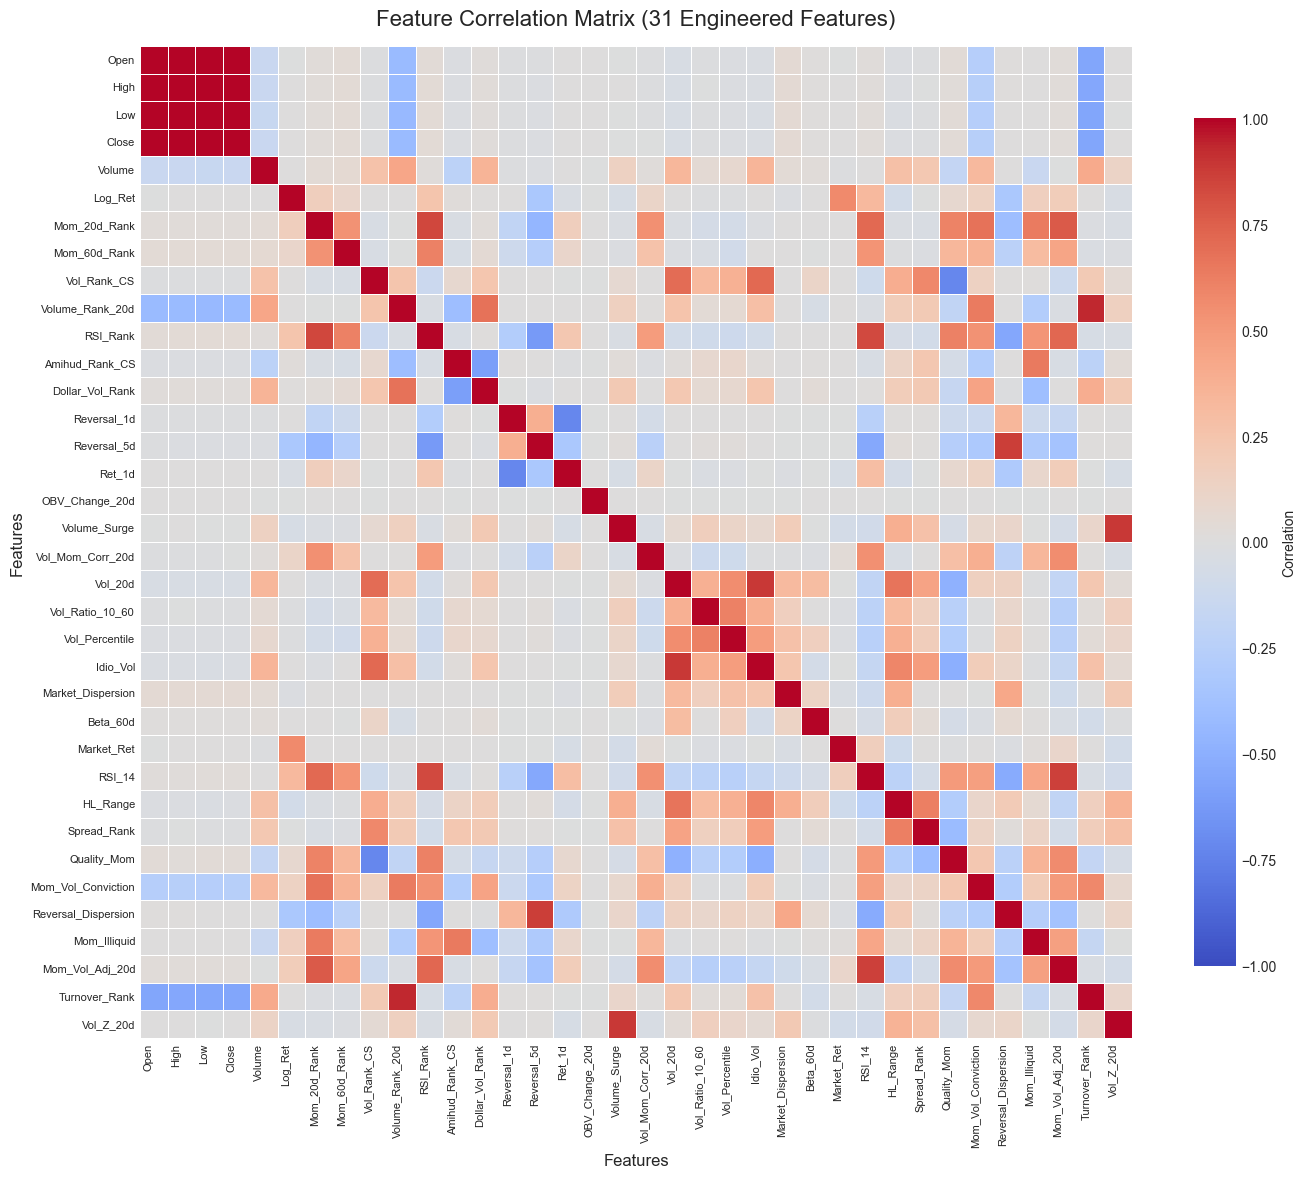

Feature correlation matrix shape: (36, 36)
Mean absolute correlation (off-diagonal): 0.147


In [11]:
# Cell #10: Feature Correlation Heatmap for Report
import matplotlib.pyplot as plt
import seaborn as sns

# Select features (exclude target column if present)
feature_cols = [c for c in df_pruned.columns if c not in ['Ticker', 'Date', 'fwd_ret_20d']]

# Compute correlation matrix
corr_matrix = df_pruned[feature_cols].corr()

# Create figure
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, 
            cmap='coolwarm', 
            center=0,
            vmin=-1, vmax=1,
            square=True,
            linewidths=0.5,
            cbar_kws={'label': 'Correlation', 'shrink': 0.8})

plt.title('Feature Correlation Matrix (31 Engineered Features)', fontsize=16, pad=15)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.xticks(rotation=90, ha='right', fontsize=8)
plt.yticks(rotation=0, fontsize=8)
plt.tight_layout()
plt.savefig('feature_correlation_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"Feature correlation matrix shape: {corr_matrix.shape}")
print(f"Mean absolute correlation (off-diagonal): {corr_matrix.abs().values[~np.eye(len(corr_matrix), dtype=bool)].mean():.3f}")